In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\Users\tejas\Documents\SportPersonClassifier


In [3]:
# Change the current working directory
new_working_directory = 'C:\Code\SportPersonClassifier\model'
os.chdir(new_working_directory)

print("Current working directory:", os.getcwd())

Current working directory: C:\Code\SportPersonClassifier\model


- **Preprocessing: Detect face and eyes**

In [4]:
img = cv2.imread('./GettyImages-1443064180.jpg')
img.shape

(1440, 2560, 3)

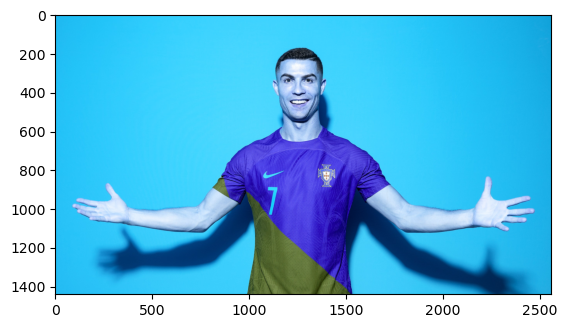

In [5]:
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1440, 2560)

In [7]:
gray

array([[183, 183, 184, ..., 161, 160, 160],
       [183, 184, 184, ..., 160, 160, 160],
       [183, 184, 184, ..., 163, 164, 164],
       ...,
       [187, 187, 188, ..., 173, 173, 173],
       [185, 186, 187, ..., 175, 175, 175],
       [184, 185, 186, ..., 172, 172, 173]], dtype=uint8)

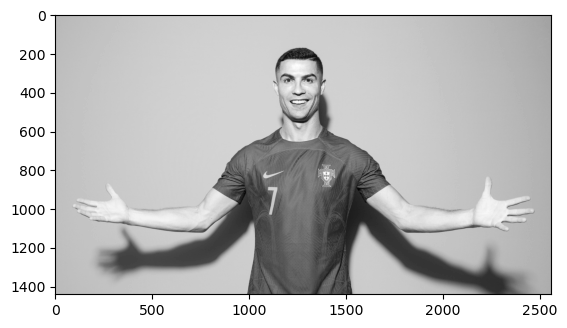

In [8]:
plt.imshow(gray, cmap='gray')

In [9]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5) # detect faces from image gray
faces

array([[1122,  234,  274,  274]])

In [10]:
(x,y,w,h) = faces[0]
x,y,w,h

(1122, 234, 274, 274)

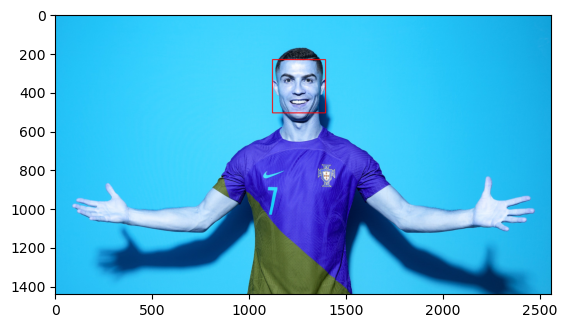

In [11]:
face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 3)
plt.imshow(face_img)

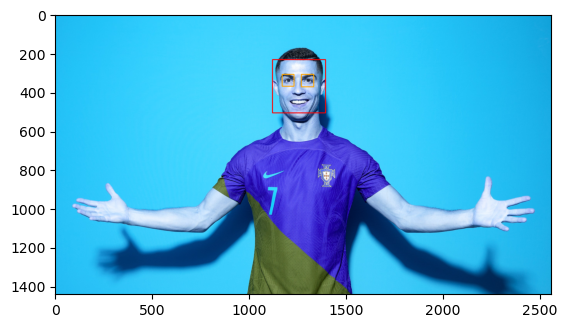

In [12]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]                #region of interest
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(255, 165, 0),3)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

> - Crop the facial region of the image

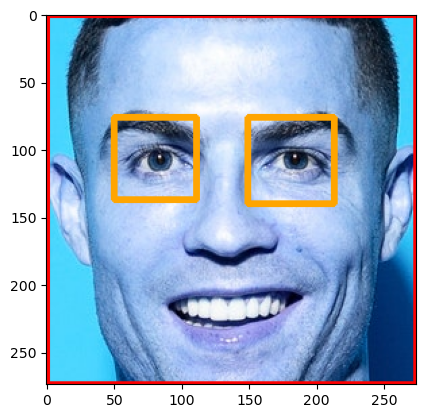

In [13]:
plt.imshow(roi_color, cmap='gray')

In [14]:
cropped_img = np.array(roi_color)
cropped_img.shape

(274, 274, 3)

- **Preprocessing: wavelet transform to extract features for model training**

In [15]:
import numpy as np
import pywt
import cv2

In [16]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

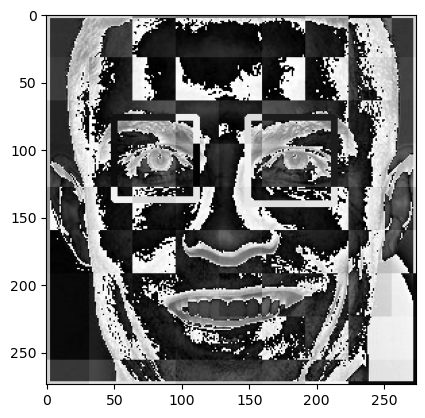

In [17]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc.

This along with raw pixel image can be used as an input for our classifier

In [18]:
import pickle

# Load celebrity_file_names_dict from the file
with open('celebrity_file_names_dict.pkl', 'rb') as file:
    celebrity_file_names_dict = pickle.load(file)

In [19]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict            #encoding

{'cristiano_ronaldo': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

- **prepare X and y**

In [20]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [21]:
len(X[0]) #each image is an array of 4096 data points

4096

In [22]:
32*32*3 + 32*32

4096

In [23]:
X[2]

array([[ 29],
       [ 23],
       [ 28],
       ...,
       [246],
       [252],
       [  1]], dtype=uint8)

In [24]:
y[2]

0

In [25]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(150, 4096)

- **Model implimentation**

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [28]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7105263157894737

In [29]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.78      0.78      0.78         9
           2       1.00      0.50      0.67        10
           3       0.67      0.80      0.73         5
           4       0.62      0.83      0.71         6

    accuracy                           0.71        38
   macro avg       0.73      0.73      0.71        38
weighted avg       0.76      0.71      0.71        38



- GridSearch to try different models with different parameters

In [30]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [31]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [32]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.748617,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.650593,{'randomforestclassifier__n_estimators': 5}
2,logistic_regression,0.847431,{'logisticregression__C': 10}


In [33]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [34]:
# check score for models with best parameters
for model_name, model in best_estimators.items():
    score = model.score(X_test, y_test)
    print(f"{model_name} score: {score}")

svm score: 0.7894736842105263
random_forest score: 0.4473684210526316
logistic_regression score: 0.7894736842105263


In [35]:
best_clf = best_estimators['logistic_regression']

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 1, 0, 2, 0],
       [0, 8, 0, 1, 0],
       [0, 1, 8, 1, 0],
       [0, 0, 1, 4, 0],
       [0, 0, 1, 0, 5]], dtype=int64)

- **Save the trained model**

In [37]:
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

- Save class dictionary

In [38]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))